Описание ситуации:
Существует процесс обработки нарушений, формируемых камерами фото и видео фиксации. Камеры детектируют различные нарушения и формируют материалы нарушения, при этом распознают номерной знак (ГРЗ, государственный регистрационный знак) транспортного средства (ТС). После этого все нарушения анализируются компетентным сотрудником (оператором) и принимается решение: оформить нарушение, или забраковать с некоторой причиной. В случае если ГРЗ распознан камерой неверно, то по нарушению получены не корректные данные о собственнике и сотрудник может изменить ГРЗ и получить корректные данные, что требует дополнительных сил и времени от сотрудника.
В существующий процесс внедрен дополнительный механизм обработки изображения ГРЗ другим математическим алгоритмом до того как материал будет передан оператору, ожидается, что использование ГРЗ от нового алгоритма позволит уменьшить кол-во замен ГРЗ оператором.

Цель:
Минимизировать трудозатраты сотрудников по замене ГРЗ

Для этого необходимо:
1. Сформировать правило (определить условия) по которому нужно изменять ГРЗ с распознанного камерой, на распознанный новым математическим аппаратом.
2. Указать и обосновать критерии корректности замены ГРЗ.
3. Оценить качество работы правила, указать экономию операций по замене ГРЗ.


Описание полей данных:
`id`              --идентификатор нарушения

`camera_id`       --идентификатор камеры сформировавшей нарушение

`time_check`      --время фиксации нарушения

`regno_recognize` --ГРЗ распознанный камерой

`regno_ai`        --ГРЗ распознанный новым математическим алгоритмом

`regno`           --ГРЗ в итоге процесса обработки нарушения (по умолчанию он равен regno_recognize, если не изменялся оператором)

`result_code`     --финальный код результата обработки нарушения (подробная расшифровка ниже)

`symbols`         --ГРЗ распознанный новым математическим алгоритмом, по символьно

`symbol_scores`   --скор уверенности нового мат. алгоритма по каждому символу из symbols (значения от 0 до 1)

`length_scores`   --скор уверенности длинны ГРЗ нового мат. алгоритма начиная с длинны 0, и до длинны 10 символов (значения от 0 до 1)



Расшифровка result_code:

0 - оформлено

1 - забраковано по причине "плохо виден ГРЗ"

2 - забраковано по причине "ошибка в адресе собственника"

3 - забраковано по причине "ошибка в иных данных собственника"

4 - забраковано по причине "плохое качество изображения"

5 - забраковано по причине "иное"


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('test_data_regno.csv', index_col=0, delimiter=';')
df.shape

(194214, 9)

Для формирования правил сперва рассмотрим работу нового мат. алгоритма.

In [ ]:
df.sample(5)

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,symbols,symbol_scores,length_scores
id,,,,,,,,,
49498,6087,08:23:14,У962КР799,У962КР799,У962КР799,0,"[""У"", ""9"", ""6"", ""2"", ""К"", ""Р"", ""7"", ""9"", ""9""]","[0.9998762607574463, 0.9999184608459473, 0.999...","[0.000000028102435933874403, 0.000000028111925..."
11451,2446,01:26:21,К066КК150,К066КК150,К066КК150,0,"[""К"", ""0"", ""6"", ""6"", ""К"", ""К"", ""1"", ""5"", ""0""]","[0.9997594952583313, 0.9998494386672974, 0.999...","[0.00000004519593588270254, 0.0000000451394228..."
136971,6445,17:01:31,Т108СВ777,Т108СВ777,Т108СВ777,0,"[""Т"", ""1"", ""0"", ""8"", ""С"", ""В"", ""7"", ""7"", ""7""]","[0.9999150037765503, 0.9999179840087891, 0.999...","[0.000000008739138301905314, 0.000000008737721..."
114534,6445,14:57:38,К112ВУ102,К112ВУ102,К112ВУ102,0,"[""К"", ""1"", ""1"", ""2"", ""В"", ""У"", ""1"", ""0"", ""2""]","[0.9999639987945557, 0.9999570846557617, 0.999...","[0.000000003273326720787395, 0.000000003292324..."
26319,1022,05:28:37,К143ОК750,К143ОК750,К143ОК750,0,"[""К"", ""1"", ""4"", ""3"", ""О"", ""К"", ""7"", ""5"", ""0""]","[0.9998573064804077, 0.9998925924301147, 0.999...","[0.00000009205538020751192, 0.0000000925627929..."


In [3]:
# Преобразуем список строк в список символов
df['symbol_scores'] = df['symbol_scores'].apply(ast.literal_eval)
df['length_scores'] = df['length_scores'].apply(ast.literal_eval)

In [4]:
# Создадим новый признак - количество символов в номерном знаке.
df['regno_len'] = df.regno_recognize.apply(lambda x: len(x))

In [5]:
# Создадим новый признак - количество символов в номерном знаке мат. алгоритма.
df["max_len_ai"] = np.argmax(df.length_scores.tolist(), axis=1)

In [6]:
# Создадим новый признак - 0 если распознанный знак мат. алгоритмом совпадает с оператором.
df['regno_ai_False'] = df.apply(lambda x: 0 if x['regno'] == x['regno_ai'] else 1, axis=1)
# Создадим новый признак - 0 если распознанный знак был заменен оператором.
df['regno_replaced'] = df.apply(lambda x: 0 if x['regno_recognize'] == x['regno'] else 1, axis=1)

In [7]:
df[df['regno_ai_False'] == 1].head(5)

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,symbols,symbol_scores,length_scores,regno_len,max_len_ai,regno_ai_False,regno_replaced
id,,,,,,,,,,,,,
11,6152,00:00:05,О037799,0037299,О037799,5,"[""0"", ""0"", ""3"", ""7"", ""2"", ""9"", ""9""]","[0.964401364326477, 0.9039003252983093, 0.9785...","[9.089479863177985e-05, 9.11558308871463e-05, ...",7,7,1,0
17,6073,00:00:08,В021799,ВО21799,В021799,5,"[""В"", ""О"", ""2"", ""1"", ""7"", ""9"", ""9""]","[0.9998476505279541, 0.9187316298484802, 0.972...","[2.5291624794476775e-08, 2.5107155465775577e-0...",7,7,1,0
34,6331,00:00:14,Н724РУ19,Н724РУ197,Н724РУ19,4,"[""Н"", ""7"", ""2"", ""4"", ""Р"", ""У"", ""1"", ""9"", ""7""]","[0.9997404217720032, 0.9997168183326721, 0.999...","[7.990223593878909e-09, 8.040183629987041e-09,...",8,9,1,0
40,770,00:00:16,С655СС793,С655ХТ190,С655СС793,4,"[""С"", ""6"", ""5"", ""5"", ""Х"", ""Т"", ""1"", ""9"", ""0""]","[0.9797039031982422, 0.9992982149124146, 0.999...","[2.5993113439426452e-08, 2.5785865886973625e-0...",9,9,1,0
59,748,00:00:26,А576ТВ190,А576ТВ199,А576ТВ198,2,"[""А"", ""5"", ""7"", ""6"", ""Т"", ""В"", ""1"", ""9"", ""9""]","[0.9999476671218872, 0.9999375343322754, 0.999...","[9.441475157245804e-09, 9.36376753912782e-09, ...",9,9,1,1


In [8]:
# развернем symbol_scores и length_scores в колонки
df_symbols = pd.DataFrame(df['symbol_scores'].to_list(), columns=[f'symb_{i}' for i in range(9)], index=df.index)
df_len = pd.DataFrame(df['length_scores'].to_list(), columns=[f'len_{i}' for i in range(11)], index=df.index)

In [9]:
df = df.merge(df_symbols,  left_index=True, right_index=True )
df = df.merge(df_len,  left_index=True, right_index=True )

In [10]:
# df['symbols_str'] = df['regno'].apply(lambda x: ''.join(x))

# добавление столбца со списком символов, не совпадающих с regno
df['mismatched_symbols'] = df.apply(lambda row: [s for s in row['regno_ai'] if s not in row['regno']], axis=1)

In [11]:
# добавление столбца со списком символов, не совпадающих с regno
df['mismatched_indices'] = df.apply(lambda row: [s for s in enumerate(row['regno_ai']) if s not in enumerate(row['regno'])], axis=1)

In [12]:
# добавление столбца со списком значений symbol_scores, соответствующих индексам несовпадающих символов
df['selected_scores'] = df.apply(lambda row: [row['symb_{}'.format(i[0])] for i in row['mismatched_indices']], axis=1)

In [13]:
df.drop(['symbols', 'symbol_scores', 'length_scores'], axis= 1, inplace= True)

In [14]:
def get_time_of_day(hour):
    if 7 <= hour < 16:
        return 'Day'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

In [15]:
# Создаем новый столбец с категориальным признаком типа часа
df['time_check'] = pd.to_datetime(df.time_check)
df['part_day'] = df['time_check'].apply(lambda x: get_time_of_day(x.hour))

In [16]:
symbols_list = ['symb_0', 'symb_1', 'symb_2', 'symb_3', 'symb_4', 'symb_5', 'symb_6', 'symb_7', 'symb_8']
len_list = ['len_0', 'len_1', 'len_2', 'len_3', 'len_4', 'len_5', 'len_6', 'len_7', 'len_8','len_9', 'len_10']

In [24]:
df

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,regno_len,max_len_ai,regno_ai_False,regno_replaced,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10,mismatched_symbols,mismatched_indices,selected_scores,part_day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,844,2023-05-24 00:00:00,У991КВ799,У991КВ799,У991КВ799,0,9,9,0,0,0.999937,0.999922,0.999883,0.999906,0.999920,0.999878,0.999733,0.999527,0.999081,3.483160e-08,3.483545e-08,3.468561e-08,3.473692e-08,3.499301e-08,3.492320e-08,3.507172e-08,1.432063e-06,0.000067,0.999931,3.498554e-08,[],[],[],Night
2,2516,2023-05-24 00:00:00,О019УК177,О019УК177,О019УК177,0,9,9,0,0,0.999899,0.999863,0.999929,0.999959,0.999959,0.999864,0.999864,0.999885,0.999973,6.847767e-09,6.833323e-09,6.833115e-09,6.841657e-09,6.851765e-09,6.867570e-09,6.858551e-09,2.581852e-08,0.000010,0.999990,6.853543e-09,[],[],[],Night
3,2476,2023-05-24 00:00:00,Е175АК150,Е175АК150,Е175АК150,0,9,9,0,0,0.999726,0.999927,0.999964,0.999946,0.999908,0.999943,0.999868,0.999798,0.999853,2.039654e-09,2.043388e-09,2.048512e-09,2.054996e-09,2.044666e-09,2.050587e-09,2.035864e-09,1.176938e-09,0.000001,0.999999,2.043193e-09,[],[],[],Night
4,1251,2023-05-24 00:00:01,Т359ОН799,Т359ОН799,Т359ОН799,0,9,9,0,0,0.999878,0.999876,0.999909,0.999907,0.999792,0.999662,0.999265,0.999297,0.999295,2.880541e-08,2.899851e-08,2.875200e-08,2.885787e-08,2.880271e-08,2.897518e-08,2.895689e-08,6.238732e-07,0.000018,0.999982,2.890938e-08,[],[],[],Night
5,2516,2023-05-24 00:00:01,В521СУ750,В521СУ750,В521СУ750,0,9,9,0,0,0.999920,0.999933,0.999909,0.999906,0.999577,0.999943,0.999951,0.999914,0.999971,9.300509e-09,9.201487e-09,9.197364e-09,9.257113e-09,9.266335e-09,9.261705e-09,9.148846e-09,1.804638e-08,0.000008,0.999992,9.211548e-09,[],[],[],Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194210,5497,2023-05-24 23:59:58,В035Т_197,В035ТС197,В035Т_197,1,9,9,1,0,0.999865,0.999917,0.999926,0.999944,0.999880,0.998932,0.999953,0.999848,0.999960,1.221202e-08,1.215782e-08,1.219880e-08,1.225413e-08,1.211229e-08,1.225851e-08,1.219784e-08,3.704831e-08,0.000003,0.999997,1.222824e-08,[С],"[(5, С)]",[0.9989319443702698],Night
194211,6320,2023-05-24 23:59:58,А974КА67,А974КА67,А974КА67,2,8,8,0,0,0.999926,0.999952,0.999959,0.999929,0.999944,0.999907,0.999740,0.999835,NaN,2.660914e-09,2.671390e-09,2.676786e-09,2.668569e-09,2.662006e-09,2.663728e-09,2.687222e-09,4.784428e-09,0.999999,0.000001,2.665817e-09,[],[],[],Night
194212,2659,2023-05-24 23:59:58,Х037НН777,Х037НН777,Х037НН777,0,9,9,0,0,0.999947,0.999940,0.999933,0.999950,0.999941,0.999775,0.999982,0.999961,0.999777,7.581427e-08,7.637028e-08,7.607805e-08,7.620004e-08,7.614425e-08,7.638469e-08,7.648762e-08,1.341406e-06,0.000126,0.999872,7.631334e-08,[],[],[],Night


In [25]:
mean_df = df.groupby('part_day').mean().iloc[:, 6:-11]
mean_df

C:\Users\Sergey\AppData\Local\Temp\ipykernel_17836\1366854393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df.groupby('part_day').mean().iloc[:, 6:-11]


,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8
part_day,,,,,,,,,
Day,0.969201,0.982643,0.986997,0.985348,0.982296,0.978661,0.981296,0.983624,0.997289
Evening,0.969787,0.983986,0.987544,0.985884,0.982922,0.979176,0.981031,0.982379,0.997412
Night,0.974869,0.982807,0.988743,0.985874,0.982374,0.978961,0.981418,0.985872,0.995880


In [18]:
print(f"Cредняя увереность мат. алгоритма: {round(mean_df.mean().mean(), 2)}")

Cредняя увереность мат. алгоритма: 0.98


Новый математический алгоритм не зависит от времени суток.

In [19]:
print(f'Всего замен ГРЗ оператором: {len(df[df.regno_replaced == 1])}')

Всего замен ГРЗ оператором: 11111


In [20]:
print(f'Всего отличий между знаком, распознанным мат. алгоритмом и оператором: {len(df[df.regno_ai_False == 1])}')

Всего отличий между знаком, распознанным мат. алгоритмом и оператором: 17863


In [26]:
df[(df.result_code != 0) &  (df.regno_replaced == 1)].sample(5)

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,regno_len,max_len_ai,regno_ai_False,regno_replaced,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10,mismatched_symbols,mismatched_indices,selected_scores,part_day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
146723,8398,2023-05-24 18:03:25,Т483НС79,Т483НС799,Т483НС799,5,8,9,0,1,0.999900,0.999945,0.999972,0.999958,0.999919,0.999883,0.999744,0.999041,0.999372,3.668808e-08,3.676977e-08,3.687730e-08,3.668500e-08,3.682395e-08,3.704049e-08,3.698317e-08,1.270283e-06,3.899288e-05,0.999959,3.689728e-08,[],[],[],Evening
181023,1081,2023-05-24 22:32:34,SSА5550_,А5555К50,55АS550,5,8,8,1,1,0.339897,0.997063,0.996521,0.961453,0.430636,0.366158,0.992928,0.825231,NaN,2.515394e-04,2.516056e-04,2.506613e-04,2.507574e-04,2.507856e-04,2.513828e-04,2.511025e-04,8.909983e-03,9.152589e-01,0.073822,2.509765e-04,[К],"[(0, А), (2, 5), (3, 5), (5, К), (6, 5), (7, 0)]","[0.3398965001106262, 0.9965211153030396, 0.961...",Night
7301,856,2023-05-24 00:51:06,Х249ТА199,Х249ТА190,Х249ТА190,3,9,9,0,1,0.999882,0.999865,0.999937,0.999882,0.999875,0.999839,0.999992,0.999942,0.999906,9.716247e-09,9.662910e-09,9.609518e-09,9.636811e-09,9.566031e-09,9.629241e-09,9.636278e-09,6.598934e-07,7.956411e-07,0.999998,9.638374e-09,[],[],[],Night
184939,1811,2023-05-24 22:58:41,_517IН4,ВР177М4,8517IМ4,5,7,8,1,1,0.885154,0.290896,0.954756,0.918049,0.977497,0.849093,0.266750,NaN,NaN,5.426792e-05,5.388454e-05,5.408765e-05,5.416291e-05,5.404562e-05,5.411882e-05,5.397167e-05,2.036435e-01,7.941247e-01,0.001799,5.405197e-05,"[В, Р]","[(0, В), (1, Р), (4, 7)]","[0.8851537108421326, 0.2908956706523895, 0.977...",Night
149680,2515,2023-05-24 18:23:01,I35_7_8,А5354Н87,I35ТN870,5,7,8,1,1,0.186779,0.871415,0.896767,0.498420,0.195891,0.217544,0.467276,0.974871,NaN,9.503761e-05,9.517347e-05,9.473447e-05,9.492021e-05,9.468794e-05,9.503815e-05,9.493660e-05,8.211575e-02,9.080781e-01,0.009046,9.512094e-05,"[А, 4, Н]","[(0, А), (1, 5), (2, 3), (3, 5), (4, 4), (5, Н...","[0.18677903711795807, 0.8714153170585632, 0.89...",Evening


In [27]:
df[(df.result_code == 1) &  (df.regno_replaced == 0)].sample(5)

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,regno_len,max_len_ai,regno_ai_False,regno_replaced,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10,mismatched_symbols,mismatched_indices,selected_scores,part_day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37700,1386,2023-05-24 07:04:10,Р265ЕЕ77,Р265ЕЕ777,Р265ЕЕ77,1,8,9,1,0,0.999944,0.999974,0.999970,0.999911,0.999882,0.999923,0.999990,0.999562,0.886136,9.120403e-07,9.144502e-07,9.115281e-07,9.060913e-07,9.145609e-07,9.116194e-07,9.137789e-07,1.675402e-05,0.023208,0.976768,9.179662e-07,[],"[(8, 7)]",[0.8861355185508728],Day
166132,2663,2023-05-24 20:30:28,К780ЕВ77,К780ЕВ77,К780ЕВ77,1,8,8,0,0,0.999929,0.999976,0.999378,0.999894,0.999963,0.999875,0.999981,0.999929,NaN,4.609096e-07,4.639467e-07,4.600484e-07,4.621578e-07,4.604869e-07,4.590246e-07,4.609474e-07,1.338391e-05,0.992532,0.007451,4.613427e-07,[],[],[],Night
182292,840,2023-05-24 22:40:59,НР96677,НР96677,НР96677,1,7,7,0,0,0.998413,0.742211,0.999926,0.999688,0.997514,0.994710,0.999808,NaN,NaN,2.567990e-07,2.559467e-07,2.541201e-07,2.547597e-07,2.569734e-07,2.549547e-07,2.554426e-07,9.997790e-01,0.000207,0.000012,2.557617e-07,[],[],[],Night
10405,2491,2023-05-24 01:16:41,Е_796К50,Е690АК50,Е_796К50,1,8,8,1,0,0.999668,0.967154,0.538996,0.807962,0.999976,0.999951,0.999882,0.999974,NaN,1.290016e-09,1.294312e-09,1.292102e-09,1.292992e-09,1.289574e-09,1.293920e-09,1.289839e-09,1.115065e-09,0.999998,0.000002,1.288578e-09,[А],"[(1, 6), (2, 9), (3, 0), (4, А)]","[0.9671538472175598, 0.5389962196350098, 0.807...",Night
53561,895,2023-05-24 08:51:48,К883УВ77,К883УВ777,К883УВ77,1,8,9,1,0,0.999900,0.999969,0.999990,0.999954,0.999939,0.999857,0.999986,0.999954,0.976628,8.158466e-07,8.146640e-07,8.124172e-07,8.121731e-07,8.141902e-07,8.114508e-07,8.138712e-07,1.209634e-05,0.022780,0.977202,8.164390e-07,[],"[(8, 7)]",[0.9766275882720947],Day


In [28]:
df[(df.result_code == 1) &  (df.regno_replaced == 1)].sample(5)

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,regno_len,max_len_ai,regno_ai_False,regno_replaced,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10,mismatched_symbols,mismatched_indices,selected_scores,part_day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
155594,746,2023-05-24 19:02:45,_397ВК799,С392ВК799,С397ВК799,1,9,9,1,1,0.999964,0.999770,0.999971,0.999935,0.999858,0.999879,0.999837,0.998385,0.999146,5.129746e-09,5.161604e-09,5.166352e-09,5.185277e-09,5.163062e-09,5.154059e-09,5.169960e-09,6.061196e-09,0.000016,0.999984,5.130255e-09,[2],"[(3, 2)]",[0.9999345541000366],Evening
169252,6235,2023-05-24 21:00:50,Х246ЕХ750,К246ЕХ750,К246ЕХ750,1,9,9,0,1,0.999268,0.999862,0.999902,0.999947,0.989956,0.999833,0.999973,0.999894,0.999960,4.869875e-08,4.850112e-08,4.828191e-08,4.851953e-08,4.847143e-08,4.821418e-08,4.825061e-08,1.063690e-06,0.000012,0.999986,4.816335e-08,[],[],[],Night
160962,6091,2023-05-24 19:43:47,Х210ХТ19,Х210ХТ199,Х210ХТ199,1,8,9,0,1,0.999852,0.999975,0.999925,0.999966,0.999954,0.999923,0.999994,0.999997,0.998520,1.608896e-08,1.586928e-08,1.598216e-08,1.606140e-08,1.590431e-08,1.601503e-08,1.606269e-08,7.010720e-07,0.000008,0.999991,1.597213e-08,[],[],[],Evening
164991,6212,2023-05-24 20:18:40,В567АК77,В567АК777,В567АК777,1,8,9,0,1,0.998471,0.998387,0.999931,0.999962,0.999805,0.999886,0.999994,0.999983,0.999853,2.507485e-08,2.505124e-08,2.496395e-08,2.504990e-08,2.516680e-08,2.506228e-08,2.502645e-08,2.623320e-08,0.000084,0.999916,2.511880e-08,[],[],[],Night
188592,6073,2023-05-24 23:22:38,А728ОР77,А728ОР777,А728ОР777,1,8,9,0,1,0.999967,0.999753,0.999982,0.999971,0.999894,0.999855,0.999998,0.999998,0.999914,4.148020e-08,4.167298e-08,4.135380e-08,4.168800e-08,4.135372e-08,4.165859e-08,4.135356e-08,3.209591e-07,0.000090,0.999909,4.145425e-08,[],[],[],Night


Разберем те случаи, в которых result_code равен 0, так как не совсем очевидна логика когда оператор меняет номера, а когда оставляет.

In [29]:
df.fillna(1, inplace=True)

In [30]:
print(f"Всего таких случаев: {df[(df.result_code == 0)].shape[0]}")

Всего таких случаев: 135289


In [31]:
# Рассмотрим ошибается ли алгоритм, если уверенность в каждом из символов больше 98 %
print(
    f"Всего таких случаев: {df[(df.result_code == 0) & (df.regno_ai_False == 1) & (df[symbols_list] > 0.98).all(axis=1)].shape[0]}")

Всего таких случаев: 33


In [32]:
print(
    f"Вероятность ошибки мат. алгоритма в таких случаях: {100 * len(df[(df.result_code == 0) & (df.regno_ai_False == 1) & (df[symbols_list] > 0.98).all(axis=1)]) / len(df[(df.result_code == 0)])}%")

Вероятность ошибки мат. алгоритма в таких случаях: 0.02439222701032604%


In [42]:
df_melted = pd.melt(df[(df.result_code == 0) & (df.regno_ai_False == 1) & ((df[symbols_list] > 0.98).sum(axis=1) >= 9)].iloc[:, 10:-15])

Text(0.5, 1.0, 'Cкор уверенности, когда новый мат. алгоритм ошибся')

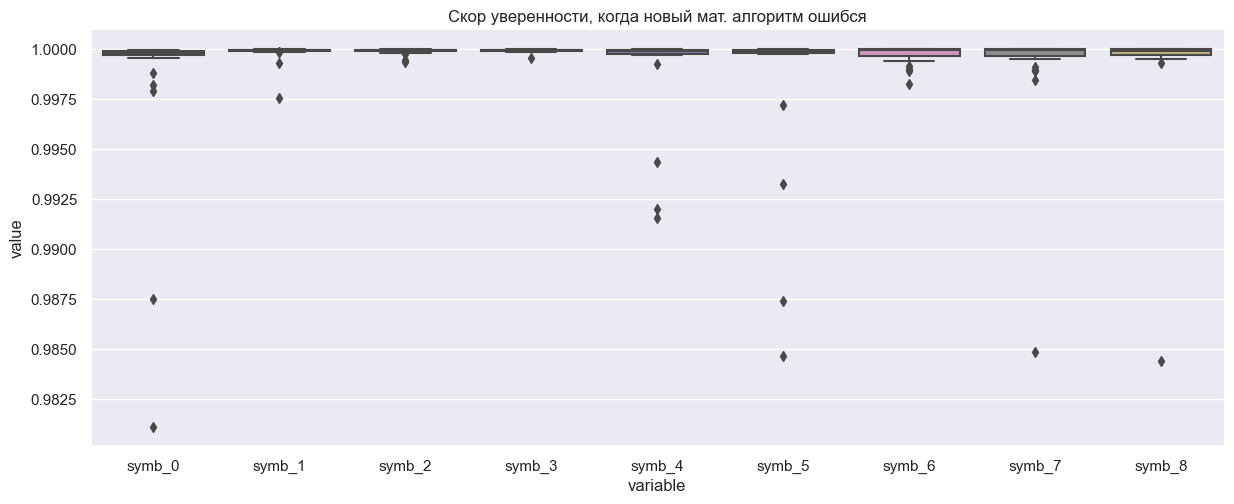

In [43]:
sns.set()
sns.catplot(x='variable', y='value', data=df_melted, kind='box',  aspect=2.5)
plt.title("Cкор уверенности, когда новый мат. алгоритм ошибся")

In [44]:
df[(df.result_code == 0) & (df.regno_ai_False == 1) & (
    df.max_len_ai != df.regno_len) & (df[symbols_list] > 0.98).all(axis=1)]

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,regno_len,max_len_ai,regno_ai_False,regno_replaced,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10,mismatched_symbols,mismatched_indices,selected_scores,part_day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
96975,6516,2023-05-24 13:19:53,Н684ТС77,Н684ТС777,Н684ТС77,0,8,9,1,0,0.999848,0.999928,0.999965,0.999945,0.999960,0.999779,0.99998,0.999986,0.999896,7.980473e-08,7.970357e-08,7.937829e-08,7.931897e-08,7.948556e-08,7.917009e-08,7.962895e-08,1.372563e-06,0.000139,0.999859,7.966147e-08,[],"[(8, 7)]",[0.9998960494995117],Day
167436,6238,2023-05-24 20:43:40,В708НР19,В708НР190,В708НР198,0,8,9,1,1,0.999954,0.999946,0.999957,0.999925,0.999704,0.999881,0.99999,0.999950,0.999293,5.460789e-09,5.446569e-09,5.448305e-09,5.471632e-09,5.455001e-09,5.509437e-09,5.452816e-09,2.760510e-08,0.000003,0.999997,5.459050e-09,[],"[(8, 0)]",[0.9992929697036743],Night


Вывод: 

При использовании математического алгоритма возможна погрешность в распознавании символов. Поэтому необходимо определить, какая точность распознавания достаточна.

Сформируем новое правило: точность по каждому из символов более 98%.

In [45]:
df[~(df[symbols_list] > 0.98).all(axis=1)].query('regno_recognize == regno_ai')

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,regno_len,max_len_ai,regno_ai_False,regno_replaced,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10,mismatched_symbols,mismatched_indices,selected_scores,part_day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90,8599,2023-05-24 00:00:38,ОА33877,ОА33877,ОА33877,0,7,7,0,0,0.997027,0.927753,0.999857,0.999987,0.999861,0.999863,0.999994,1.000000,1.000000,4.110401e-10,4.116686e-10,4.070177e-10,4.100199e-10,4.094212e-10,4.108646e-10,4.101255e-10,0.999999,7.275821e-07,6.208528e-10,4.109398e-10,[],[],[],Night
98,6223,2023-05-24 00:00:43,А418299,А418299,А418299,5,7,7,0,0,0.999979,0.536292,0.917227,0.998871,0.998538,0.998279,0.999971,1.000000,1.000000,1.360611e-08,1.355836e-08,1.347326e-08,1.358958e-08,1.349301e-08,1.353508e-08,1.349991e-08,0.999605,3.939705e-04,7.454415e-07,1.357658e-08,[],[],[],Night
212,708,2023-05-24 00:01:23,О939199,О939199,О939199,5,7,7,0,0,0.999448,0.809506,0.998548,0.995957,0.977877,0.933714,0.999964,1.000000,1.000000,3.022231e-07,2.998955e-07,3.005088e-07,3.005199e-07,3.010170e-07,3.024059e-07,3.012318e-07,0.995296,4.688733e-03,1.272963e-05,3.001338e-07,[],[],[],Night
223,870,2023-05-24 00:01:29,О984ВА799,О984ВА799,О984ВА799,4,9,9,0,0,0.990102,0.999724,0.996970,0.997713,0.859560,0.961464,0.962022,0.999464,0.994538,4.508167e-06,4.518411e-06,4.521143e-06,4.518497e-06,4.527534e-06,4.511349e-06,4.529715e-06,0.000078,1.421492e-02,9.856706e-01,4.505038e-06,[],[],[],Night
232,8599,2023-05-24 00:01:33,ОА44477,ОА44477,ОА44477,0,7,7,0,0,0.991634,0.806353,0.999946,0.999503,0.999122,0.998174,0.999915,1.000000,1.000000,1.403053e-08,1.396757e-08,1.389455e-08,1.394648e-08,1.396256e-08,1.389717e-08,1.398060e-08,0.999993,5.360319e-06,1.163456e-06,1.397407e-08,[],[],[],Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193974,6445,2023-05-24 23:58:09,РР24177,РР24177,РР24177,1,7,7,0,0,0.999875,0.943196,0.999987,0.999984,0.999592,0.999967,0.999890,1.000000,1.000000,3.025381e-08,3.012362e-08,3.015063e-08,2.989301e-08,3.026160e-08,3.014270e-08,2.997037e-08,0.999961,3.895278e-05,2.136927e-07,3.011517e-08,[],[],[],Night
194127,7140,2023-05-24 23:59:20,О921699,О921699,О921699,5,7,7,0,0,0.998958,0.784335,0.996446,0.981910,0.998730,0.724836,0.999559,1.000000,1.000000,1.610126e-07,1.601233e-07,1.598247e-07,1.605534e-07,1.613013e-07,1.608182e-07,1.611222e-07,0.997685,2.070267e-03,2.434370e-04,1.611532e-07,[],[],[],Night
194148,6323,2023-05-24 23:59:29,У621199,У621199,У621199,5,7,7,0,0,0.999810,0.627555,0.948122,0.988033,0.998898,0.682495,0.999906,1.000000,1.000000,2.727858e-08,2.717835e-08,2.715073e-08,2.687452e-08,2.726469e-08,2.720900e-08,2.717431e-08,0.999916,8.361241e-05,1.836688e-07,2.724016e-08,[],[],[],Night


In [46]:
df[len_list].describe()

,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10
count,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05,1.942140e+05
mean,7.347708e-06,7.345873e-06,7.345989e-06,7.347680e-06,7.345043e-06,7.345692e-06,7.344029e-06,4.896398e-02,2.217658e-01,7.292115e-01,7.349435e-06
std,1.129725e-04,1.129408e-04,1.129999e-04,1.130335e-04,1.129586e-04,1.129710e-04,1.129798e-04,2.086508e-01,4.109739e-01,4.420492e-01,1.130078e-04
min,5.929314e-20,5.859542e-20,5.874336e-20,5.932232e-20,5.886247e-20,5.923955e-20,5.929631e-20,8.784253e-18,1.490141e-11,6.136473e-13,5.849336e-20
25%,6.679664e-09,6.676546e-09,6.676038e-09,6.687314e-09,6.685077e-09,6.693892e-09,6.683232e-09,4.458629e-08,7.178317e-06,4.100443e-03,6.679099e-09
50%,1.596140e-08,1.596041e-08,1.594764e-08,1.596996e-08,1.597312e-08,1.599132e-08,1.597672e-08,2.403512e-07,2.203191e-05,9.999754e-01,1.595320e-08
75%,3.945768e-08,3.943367e-08,3.937224e-08,3.942311e-08,3.945319e-08,3.947184e-08,3.946054e-08,1.222568e-06,1.661662e-03,9.999918e-01,3.942949e-08
max,1.529451e-02,1.527694e-02,1.529735e-02,1.529771e-02,1.528644e-02,1.528900e-02,1.529129e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.529781e-02


In [47]:
df[~(((df[len_list] > 0.98).any(axis=1)) & ((df[symbols_list] > 0.98).all(axis=1)))] \
.query('regno_recognize != regno_ai & result_code != 0')

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,regno_len,max_len_ai,regno_ai_False,regno_replaced,symb_0,symb_1,symb_2,symb_3,symb_4,symb_5,symb_6,symb_7,symb_8,len_0,len_1,len_2,len_3,len_4,len_5,len_6,len_7,len_8,len_9,len_10,mismatched_symbols,mismatched_indices,selected_scores,part_day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,6152,2023-05-24 00:00:05,О037799,0037299,О037799,5,7,7,1,0,0.964401,0.903900,0.978584,0.998873,0.437422,0.690234,0.966736,1.000000,1.000000,9.089480e-05,9.115583e-05,9.128945e-05,9.146601e-05,9.143653e-05,9.117121e-05,9.119130e-05,7.884713e-01,0.155411,0.055389,9.085380e-05,[2],"[(0, 0), (4, 2)]","[0.964401364326477, 0.4374215602874756]",Night
17,6073,2023-05-24 00:00:08,В021799,ВО21799,В021799,5,7,7,1,0,0.999848,0.918732,0.972389,0.885471,0.999102,0.994941,0.999810,1.000000,1.000000,2.529162e-08,2.510716e-08,2.525701e-08,2.523289e-08,2.533542e-08,2.527590e-08,2.507916e-08,9.996926e-01,0.000306,0.000002,2.515231e-08,[О],"[(1, О)]",[0.9187316298484802],Night
40,770,2023-05-24 00:00:16,С655СС793,С655ХТ190,С655СС793,4,9,9,1,0,0.979704,0.999298,0.999919,0.999834,0.999220,0.638909,0.999856,0.999842,0.998462,2.599311e-08,2.578587e-08,2.579856e-08,2.594121e-08,2.573982e-08,2.596408e-08,2.596259e-08,6.720236e-08,0.000024,0.999976,2.587440e-08,"[Х, Т, 1, 0]","[(4, Х), (5, Т), (6, 1), (8, 0)]","[0.9992196559906006, 0.6389093399047852, 0.999...",Night
59,748,2023-05-24 00:00:26,А576ТВ190,А576ТВ199,А576ТВ198,2,9,9,1,1,0.999948,0.999938,0.999975,0.999939,0.999902,0.999109,0.999998,0.999959,0.675477,9.441475e-09,9.363768e-09,9.354627e-09,9.472879e-09,9.377154e-09,9.352379e-09,9.351719e-09,1.014352e-07,0.000002,0.999998,9.380392e-09,[],"[(8, 9)]",[0.6754770874977112],Night
67,7145,2023-05-24 00:00:28,О085897,ОО85899,О085897,5,7,7,1,0,0.999003,0.540804,0.998528,0.998647,0.990056,0.990948,0.999792,1.000000,1.000000,2.260078e-07,2.277148e-07,2.262919e-07,2.265082e-07,2.271998e-07,2.265475e-07,2.280108e-07,9.938828e-01,0.006107,0.000008,2.269075e-07,[],"[(1, О), (6, 9)]","[0.5408037304878235, 0.99979168176651]",Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194100,712,2023-05-24 23:59:08,КЕ049079,К204НВ79,КЕ049079,4,8,8,1,0,0.997367,0.999564,0.999853,0.999966,0.999479,0.992439,0.999949,0.831054,1.000000,1.261783e-06,1.268083e-06,1.258113e-06,1.256980e-06,1.263392e-06,1.255479e-06,1.262489e-06,9.645309e-05,0.993748,0.006146,1.262769e-06,"[2, Н, В]","[(1, 2), (4, Н), (5, В)]","[0.9995643496513367, 0.9994788765907288, 0.992...",Night
194158,2515,2023-05-24 23:59:33,75N871НА,Т5071А6,75N871НА,5,8,8,1,0,0.846479,0.952503,0.336282,0.399568,0.195162,0.362692,0.237772,1.000000,1.000000,4.171203e-04,4.155968e-04,4.168272e-04,4.146721e-04,4.162703e-04,4.166341e-04,4.167489e-04,6.195462e-02,0.931453,0.003262,4.165354e-04,"[Т, 0, 6]","[(0, Т), (2, 0), (3, 7), (4, 1), (5, А), (6, 6)]","[0.8464792966842651, 0.33628249168395996, 0.39...",Night
194180,6367,2023-05-24 23:59:40,4836КХ4,Т488КХ44,4836КХ4,5,7,8,1,0,0.445955,0.896463,0.999828,0.918942,0.999590,0.998899,0.797160,0.535011,1.000000,5.488866e-07,5.482480e-07,5.509625e-07,5.474026e-07,5.481559e-07,5.485476e-07,5.494225e-07,1.823781e-06,0.999902,0.000092,5.475629e-07,[Т],"[(0, Т), (1, 4), (2, 8), (3, 8), (7, 4)]","[0.4459550082683563, 0.8964633941650391, 0.999...",Night


Итоговые правила для замены ГРЗ новым мат. алгоритмом:
 - Если regno_recognize и regno_ai полностью совпадают, то не изменяем ГРЗ.
 - Если regno_recognize и regno_ai не совпадают, то проверяем скор уверенности нового мат. алгоритма по каждому символу ГРЗ и длинну ГРЗ. Если скоры уверенности нового мат. алгоритма выше 
 98% для всех символов и длинны ГРЗ, то заменяем regno_recognize на regno_ai. Если скоры уверенности не достигают порога, то не изменяем ГРЗ.
 
Экономия операций по замене ГРЗ будет состоять в разнице между количеством замен до и после внедрения нового алгоритма. Чем больше экономия, тем более эффективно работает новое правило.

Оценим качество работы правила.

In [ ]:
ai_regno = len(df[((df[len_list] > 0.98).any(axis=1)) & ((df[symbols_list] > 0.98)
                                                         .all(axis=1)) & (df.result_code == 0)].query('regno_recognize != regno_ai'))

ai_false = len(df[((df[len_list] > 0.98).any(axis=1)) & ((df[symbols_list] > 0.98)
                                                         .all(axis=1)) & (df.result_code == 0) & (df.regno_ai_False == 1)].query('regno_recognize != regno_ai'))

In [ ]:
print(f"Замен ГРЗ по сформированным правилам: {ai_regno}")
print(f"Замен ГРЗ оператором: {ai_false} ")
print(f"Замен ГРЗ оператором до: {len(df[(df.result_code == 0) & (df.regno_replaced == 1)])} ")
print(f"Итого замен ГРЗ оператором после: {len(df[(df.result_code == 0) & (df.regno_replaced == 1)]) + ai_false - ai_regno}")

Замен ГРЗ по сформированным правилам: 7884
Замен ГРЗ оператором: 25 
Замен ГРЗ оператором до: 8223 
Итого замен ГРЗ оператором после: 364


Благодаря новому правилу удалось значительно сократить количество операций по замене ГРЗ оператором в тех случаях, когда штраф был оформлен.

In [ ]:
ai_regno_other = len(df[((df[len_list] > 0.98).any(axis=1)) & ((df[symbols_list] > 0.98)
                                                               .all(axis=1)) & (df.result_code != 0)].query('regno_recognize != regno_ai'))

ai_false_other = len(df[((df[len_list] > 0.98).any(axis=1)) & ((df[symbols_list] > 0.98)
                                                               .all(axis=1)) & (df.result_code != 0) & (df.regno_ai_False == 1)].query('regno_recognize != regno_ai'))

In [ ]:
print(f"Замен ГРЗ по сформированным правилам: {ai_regno_other}")
print(f"Замен ГРЗ оператором: {ai_false_other} ")
print(f"Замен ГРЗ оператором до: {len(df[(df.result_code != 0) & (df.regno_replaced == 1)])} ")
print(f"Итого замен ГРЗ оператором после: {len(df[(df.result_code != 0) & (df.regno_replaced == 1)]) + ai_false_other - ai_regno_other}")

Замен ГРЗ по сформированным правилам: 3475
Замен ГРЗ оператором: 1878 
Замен ГРЗ оператором до: 2888 
Итого замен ГРЗ оператором после: 1291


В остальных случаях использование новых правил также позволило уменьшить количество замен ГРЗ оператором.